# Create Centered Images

## Download the dataset

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import torch
print(torch.__version__)

!{sys.executable} -m pip install ipywidgets
# !{sys.executable} -m pip uninstall -y torch cudatoolkit
!{sys.executable} -m pip install -U -r requirements.txt
# !{sys.executable} -c "import torch.fx"

/opt/conda/envs/pytorch/bin/python3
3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
1.9.0
  Using cached gwpy-3.0.5-py3-none-any.whl (1.4 MB)
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached matplotlib-3.5.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached matplotlib-3.4.3-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached matplotlib-3.4.1-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached matplotlib-3.4.0-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached matplotlib-3.3.4-cp37-cp37m-manylinux1_x86_64.whl

In [2]:
from os import path, symlink, makedirs
from shutil import copy2, move

BASE_DIR = '.'
DATA_DIR = 'data'

ORIGIN_DATA = '/data/datasets/intertwin-dati-aux/O3a_SL_aux.tar.gz'
ORIGIN_DATA_MODE = 'copy' # copy, move or link

INPUT_FILE_TGZ = 'O3a_SL_aux.tar.gz'
AUX_FILES_DIR = 'O3a_scatt_light_aux'

ALL_CHANNELS_DATASET_DIR = 'all_channels_images'
PIX2PIX_DATASET_DIR = 'aux_channel_two'
CYCLEGAN_DATASET_DIR = 'aux_channel_two_cycle'

DATA_PATH = path.join(BASE_DIR, DATA_DIR)
TAR_PATH = path.join(DATA_PATH, INPUT_FILE_TGZ)
AUX_FILES_PATH = path.join(DATA_PATH, AUX_FILES_DIR)

def create_dir_if_needed(target_path):
    if not path.exists(target_path):
        makedirs(target_path)

def setup_origin_data():
    create_dir_if_needed(DATA_PATH)
    
    if ORIGIN_DATA_MODE == 'copy':
        copy2(ORIGIN_DATA, TAR_PATH)
        return
 
    if ORIGIN_DATA_MODE == 'move':
        move(ORIGIN_DATA, TAR_PATH)
        return
    
    if ORIGIN_DATA_MODE == 'link':
        symlink(ORIGIN_DATA, TAR_PATH)
        return

setup_origin_data()

ALL_CHANNELS_DATASET_PATH = path.join(BASE_DIR, ALL_CHANNELS_DATASET_DIR)
PIX2PIX_DATASET_PATH = path.join(BASE_DIR, PIX2PIX_DATASET_DIR)
CYCLEGAN_DATASET_PATH = path.join(BASE_DIR, CYCLEGAN_DATASET_DIR)


In [3]:
import tarfile

already_extracted = False

if not already_extracted:
    with tarfile.open(TAR_PATH) as tar:
        tar.extractall(path=DATA_PATH)

## Create the list of available files

In [4]:
import os

create_dir_if_needed(target_path=AUX_FILES_PATH)

files_paths = [elem for elem in [os.path.join(AUX_FILES_PATH, path) for path in os.listdir(AUX_FILES_PATH)] if elem[-3:] == '.h5']

## Plot the q-scan

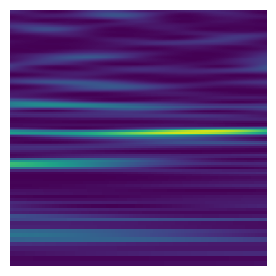

In [5]:
import h5py as h5 
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np

### Gather file
file_dir = files_paths[0]
fid = h5.File(file_dir, 'r')

### Gather data of all channels from file
grp_name = file_dir[:-3].split('/')[-1]
group_data = fid[grp_name]

### Gather data of strain channel
strain_channel = group_data['V1:Hrec_hoft_16384Hz']

### Create TimeSeries object
t = TimeSeries(strain_channel[()])
t.t0 = strain_channel.attrs['t0']
t.dt = 1.0 / strain_channel.attrs['sample_rate']

### Create q-scan in the 2 seconds interval
t0_scan = (t.times[0] + (t.times[-1] - t.times[0]) / 2).value
dt_scan = 0.5
hq = t.q_transform(outseg=(t0_scan - dt_scan, t0_scan + dt_scan), frange=(10, 100))

### Create figure and mesh with this period scan
fig = plt.figure(frameon=False, figsize=(3.21, 2.56), dpi=100)  # figsize values are set accordingly to obtain a 256x256 image
ax = fig.add_axes([0, 0, 1, 1])
mesh = ax.pcolormesh(hq)
plt.close(fig)

### Get maximum energy value from the mesh
mesh_data = mesh.get_array()
mesh_max = np.amax(mesh_data)
indices = np.where(mesh_data == mesh_max)
index = indices[0][0] % hq.times.value.shape[0]
time_val = hq.times.value[index]
dt_max = 0.25 # Interval of time around maximum value

### Create q-scan in the proper time period
hq = t.q_transform(outseg=(time_val - dt_max, time_val + dt_max), frange=(10, 100))

### Create figure with proper size and no frame
fig = plt.figure(frameon=False, figsize=(3.21, 2.56), dpi=100)  # figsize values are set accordingly to obtain a 256x256 image
ax = fig.add_axes([0, 0, 1, 1])
mesh = ax.pcolormesh(hq)
mesh.set_clim(0, 26)
cbar = fig.colorbar(mesh, label="Normalised energy")
ax.grid(False)
ax.axis('off')
ax.set_yscale('log')
cbar.remove()

## Plot q-scan for all the auxiliary channels

In [6]:
figures = []
    
for key in group_data.keys():
    
    dataset = group_data[key]
    
    # Create TimeSeries
    t = TimeSeries(dataset[()])
    t.t0 = dataset.attrs['t0']
    t.dt = 1.0 / dataset.attrs['sample_rate']
    
    # Calculate q-transform
    t0_scan = t.times[t.times.shape[0]//2].value
    dt_scan = 2.0
    hq = t.q_transform(outseg=(t0_scan - dt_scan, t0_scan + dt_scan), frange=(10, 100))
    
    # Create Figure
    fig = plt.figure(frameon=False, figsize=(3.21, 2.56), dpi=200)  # figsize values are set accordingly to obtain a 256x256 image
    ax = fig.add_axes([0, 0, 1, 1])
    mesh = ax.pcolormesh(hq)
    mesh.set_clim(0, 30)
    cbar = fig.colorbar(mesh, label="Normalised energy")
    ax.grid(False)
    ax.axis('off')
    ax.set_yscale('log')
    cbar.remove()
    plt.close(fig)
        
    figures.append(fig)

## Compress the images into a single large one

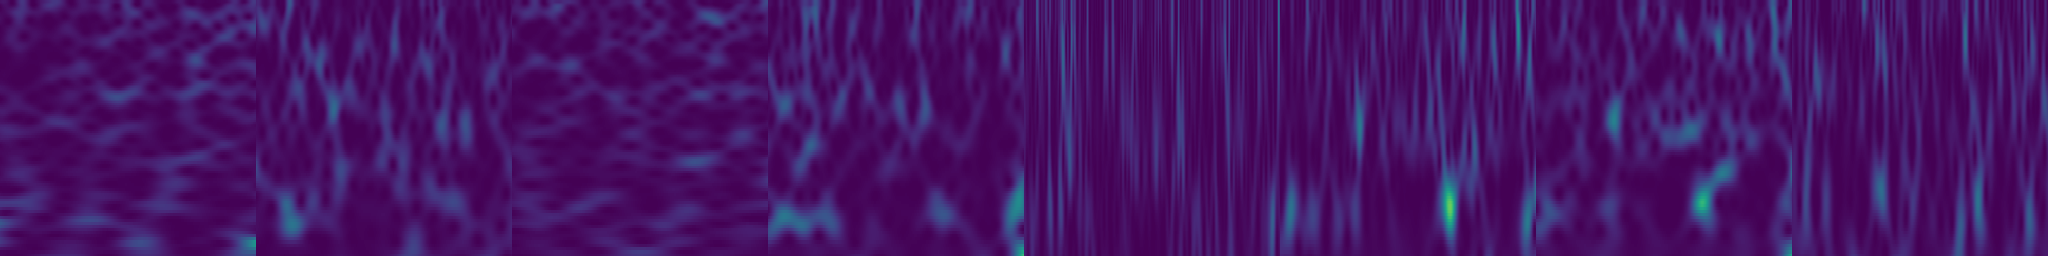

In [7]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def figures_to_tensors(figs):
    tensor_figs = []
    transform = transforms.ToTensor()
    
    for fig in figs:
        fig.canvas.draw()
        buffer = np.array(fig.canvas.renderer.buffer_rgba())
        image = Image.fromarray(buffer[:256, :256, :3])
        tensor_figs.append(transform(image))
    
    return tensor_figs

tens = figures_to_tensors(figures)
final_fig = torch.cat([tensor for tensor in tens], -1)
transform = transforms.ToPILImage()
final_image = transform(final_fig)

final_image

## Put all the preciding into a function

In [8]:
def plots(file_number):

    ### Gather file
    file_dir = files_paths[file_number]
    fid = h5.File(file_dir, 'r')

    ### Gather data of all channels from file
    grp_name = file_dir[:-3].split('/')[-1]
    group_data = fid[grp_name]
    
    figures = []
    
    for key in group_data.keys():

        dataset = group_data[key]

        # Create TimeSeries
        t = TimeSeries(dataset[()])
        t.t0 = dataset.attrs['t0']
        t.dt = 1.0 / dataset.attrs['sample_rate']

        # Calculate q-transform
        t0_scan = t.times[t.times.shape[0]//2].value
        dt_scan = 0.5
        hq = t.q_transform(outseg=(t0_scan - dt_scan, t0_scan + dt_scan), frange=(10, 100))

        ### Create figure and mesh with this period scan
        fig = plt.figure(frameon=False, figsize=(3.21, 2.56), dpi=100)  # figsize values are set accordingly to obtain a 256x256 image
        ax = fig.add_axes([0, 0, 1, 1])
        mesh = ax.pcolormesh(hq)
        plt.close(fig)

        ### Get maximum energy value from the mesh
        mesh_data = mesh.get_array()
        mesh_max = np.amax(mesh_data)
        indices = np.where(mesh_data == mesh_max)
        index = indices[0][0] % hq.times.value.shape[0]
        time_val = hq.times.value[index]
        dt_max = 0.25  # Interval of time around maximum value

        ### Create q-scan in the proper time period
        hq = t.q_transform(outseg=(time_val - dt_max, time_val + dt_max), frange=(10, 100))

        # Create Figure
        fig = plt.figure(frameon=False, figsize=(3.21, 2.56), dpi=100)  # figsize values are set accordingly to obtain a 256x256 image
        ax = fig.add_axes([0, 0, 1, 1])
        mesh = ax.pcolormesh(hq)
        mesh.set_clim(0, 30)
        cbar = fig.colorbar(mesh, label="Normalised energy")
        ax.grid(False)
        ax.axis('off')
        ax.set_yscale('log')
        cbar.remove()
        plt.close(fig)

        figures.append(fig)
        
    tens = figures_to_tensors(figures)
    final_fig = torch.cat([tensor for tensor in tens], -1)
    transform = transforms.ToPILImage()
    final_image = transform(final_fig)
    
    return final_image

## Save the images locally

In [ ]:
savedir = ALL_CHANNELS_DATASET_PATH

create_dir_if_needed(target_path=savedir)

already_done = False

if not already_done:
    length = len(files_paths)
    for i in range(length):
        final_image = plots(i)
        final_image.save(path.join(savedir, f'ch_img{i:05d}.png'))
        print(f'{i}/{length} done.')

0/855 done.
1/855 done.
2/855 done.
3/855 done.
4/855 done.
5/855 done.
6/855 done.
7/855 done.
8/855 done.
9/855 done.
10/855 done.
11/855 done.
12/855 done.
13/855 done.
14/855 done.
15/855 done.
16/855 done.
17/855 done.
18/855 done.
19/855 done.
20/855 done.
21/855 done.
22/855 done.
23/855 done.
24/855 done.
25/855 done.
26/855 done.
27/855 done.
28/855 done.
29/855 done.
30/855 done.
31/855 done.
32/855 done.
33/855 done.
34/855 done.
35/855 done.
36/855 done.
37/855 done.
38/855 done.
39/855 done.
40/855 done.
41/855 done.
42/855 done.
43/855 done.
44/855 done.
45/855 done.
46/855 done.
47/855 done.
48/855 done.
49/855 done.
50/855 done.
51/855 done.
52/855 done.
53/855 done.
54/855 done.
55/855 done.
56/855 done.
57/855 done.
58/855 done.
59/855 done.
60/855 done.
61/855 done.
62/855 done.
63/855 done.
64/855 done.
65/855 done.
66/855 done.
67/855 done.
68/855 done.
69/855 done.
70/855 done.
71/855 done.
72/855 done.
73/855 done.
74/855 done.
75/855 done.
76/855 done.
77/855 do

## Merge some images into a single big one

In [14]:
images_list = os.listdir(savedir)
images_list = [path.join(savedir, x) for x in images_list if x[-4:] == '.png']
images_list.sort(key=lambda x: int(x.split('g')[-2].split('.')[0]))
### How many files we want to include in the same picture?
images_list = images_list[:20]

imgs = [Image.open(i) for i in images_list]

min_img_width = min(i.width for i in imgs)

total_height = 0
for i, img in enumerate(imgs):
    # If the image is larger than the minimum width, resize it
    if img.width > min_img_width:
        imgs[i] = img.resize((min_img_width, int(img.height / img.width * min_img_width)), Image.ANTIALIAS)
    total_height += imgs[i].height

# Now that we know the total height of all of the resized images, we know the height of our final image
img_merge = Image.new(imgs[0].mode, (min_img_width, total_height))
y = 0
for img in imgs:
    img_merge.paste(img, (0, y))

    y += img.height
img_merge.save('multiple_files_img.png')

### Build Pix2Pix dataset

In [15]:
ch_images = [path.join(savedir, x) for x in os.listdir(savedir) if x[-4:] == '.png']

to_tensor = transforms.ToTensor()
to_image = transforms.ToPILImage()

In [16]:
num = 2  # The aux channel number that we want to consider: should go from 1 to 7

ch_img_dir = PIX2PIX_DATASET_PATH

create_dir_if_needed(target_path=ch_img_dir)
create_dir_if_needed(target_path=path.join(ch_img_dir, 'train'))
create_dir_if_needed(target_path=path.join(ch_img_dir, 'test'))

train_size = 600

for i in range(len(ch_images)):
    tens = to_tensor(Image.open(ch_images[i]))

    first_tens = tens[:, :, :256]
    second_tens = tens[:, :, 256*num:256*(num+1)]

    final_tens = torch.cat((first_tens, second_tens), 2)

    image = to_image(final_tens)

    if i < train_size:
        image.save(path.join(ch_img_dir, 'train', f'img{i}.png'))
    else:
        image.save(path.join(ch_img_dir, 'test', f'img{i-train_size}.png'))

### Bluid cycleGAN dataset

In [18]:
num = 2  # The aux channel number that we want to consider

ch_img_dir = CYCLEGAN_DATASET_PATH

create_dir_if_needed(target_path=ch_img_dir)
create_dir_if_needed(target_path=path.join(ch_img_dir, 'train', 'strain'))
create_dir_if_needed(target_path=path.join(ch_img_dir, 'train', 'aux'))
create_dir_if_needed(target_path=path.join(ch_img_dir, 'test', 'strain'))
create_dir_if_needed(target_path=path.join(ch_img_dir, 'test', 'aux'))

train_size = 600

for i in range(len(ch_images)):
    tens = to_tensor(Image.open(ch_images[i]))

    first_tens = tens[:, :, :256]
    second_tens = tens[:, :, 256*num:256*(num+1)]
    
    strain_tens = torch.cat((first_tens, second_tens), 2)
    aux_tens = torch.cat((second_tens, first_tens), 2)

    image1 = to_image(strain_tens)
    image2 = to_image(aux_tens)

    if i < train_size:
        image1.save(path.join(ch_img_dir, 'train', 'strain', f'img{i}.png'))
        image2.save(path.join(ch_img_dir, 'train', 'aux', f'img{i}.png'))
    else:
        image1.save(path.join(ch_img_dir, 'test', 'train', f'img{i-train_size}.png'))
        image2.save(path.join(ch_img_dir, 'test', 'aux', f'img{i-train_size}.png'))